# Confusion Matrices Building

## Step 1. Preparation.

### 1.1. Importing libraries.

In [31]:
from __future__ import annotations

# System imports
import random, os
from typing import List, TypeAlias
from pathlib import Path
from enum import IntEnum

# Core imports
import tensorflow as tf
import numpy as np

# Sklearn imports
from sklearn.metrics import confusion_matrix

# Display imports
from matplotlib import pyplot as plt

# Helper imports
import pickle
import itertools

def tf_seed(seed=0):
    np.random.seed(seed)  # numpy seed
    tf.random.set_seed(seed)  # tensorflow seed
    random.seed(seed)  # random seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED'] = str(seed)

### 1.2. Preparing to load all datasets and models.

In [67]:
class DatasetSource(IntEnum):
    MSSPOOF = 1
    _3DMAD = 2
    CSMAD = 3
    REPLAY_ATTACK = 4
    OUR = 5
    
    def dataset_path(self) -> Path:
        return {
            DatasetSource.MSSPOOF.value: Path('./datasets/msspoof'),
            DatasetSource._3DMAD.value: Path('./datasets/3dmad'),
            DatasetSource.CSMAD.value: Path('./datasets/csmad'),
            DatasetSource.REPLAY_ATTACK.value: Path('./datasets/replay_attack'),
            DatasetSource.OUR.value: Path('./datasets/our.array')
        }[self.value]
    
    @classmethod
    def to_list(cls) -> List[DatasetSource]:
        return list(cls)
    
    def model(self) -> tf.keras.Model:
        return {
            DatasetSource.MSSPOOF.value: tf.keras.models.load_model("./models/model_MSSpoof.h5"),
            DatasetSource._3DMAD.value: tf.keras.models.load_model("./models/model_3DMAD.h5"),
            DatasetSource.CSMAD.value: tf.keras.models.load_model("./models/model_CSMAD.keras"),
            DatasetSource.REPLAY_ATTACK.value: tf.keras.models.load_model("./models/model_Replay_Attack.h5"),
            DatasetSource.OUR.value: tf.keras.models.load_model("./models/model_our.h5")
        }[self.value]

In [68]:
# Testing the Dataset enum
print(DatasetSource.REPLAY_ATTACK.dataset_path())
print(DatasetSource._3DMAD.dataset_path())

datasets/replay_attack
datasets/3dmad


## Step 2. Dataset loading

In [69]:
# Dataset type specification.
# Dataset consists of 4 numpy arrays:
# 1. Training data
# 2. Validation data
# 3. Training labels
# 4. Validation labels
Dataset: TypeAlias = (np.ndarray, np.ndarray, np.ndarray, np.ndarray)

class DatasetLoader:
    """
    Dataset loader class.
    """
    
    @staticmethod
    def _load_3dmad() -> Dataset:
        (X_train, X_test, y_train, y_test) = pickle.loads(
            open(DatasetSource._3DMAD.dataset_path(), "rb").read())
        return X_train, X_test, y_train, y_test

    @staticmethod
    def _load_csmad() -> Dataset:
        (X_train, X_test, y_train, y_test) = pickle.loads(
            open(DatasetSource.CSMAD.dataset_path(), "rb").read())
        # Cutting off the alpha channel
        X_train = X_train[..., :3]
        X_test = X_test[..., :3]
        return X_train, X_test, y_train, y_test

    @staticmethod
    def _load_our() -> Dataset:
        (X_train, X_test, y_train, y_test, _, _) = pickle.loads(
            open(DatasetSource.OUR.dataset_path(), "rb").read())
        return X_train, X_test, y_train, y_test

    @staticmethod
    def _load_replay_attack() -> Dataset:
        (X_train, X_test, y_train, y_test) = pickle.loads(
            open(DatasetSource.REPLAY_ATTACK.dataset_path(), "rb").read())
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def _load_msspoof() -> Dataset:
        (X_train, X_test, y_train, y_test) = pickle.loads(
            open(DatasetSource.MSSPOOF.dataset_path(), "rb").read())
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def load_dataset(dataset: DatasetSource) -> Dataset:
        """
        Loads the dataset from the specified source.
        """
        return {
            DatasetSource.MSSPOOF: DatasetLoader._load_msspoof,
            DatasetSource._3DMAD: DatasetLoader._load_3dmad,
            DatasetSource.CSMAD: DatasetLoader._load_csmad,
            DatasetSource.REPLAY_ATTACK: DatasetLoader._load_replay_attack,
            DatasetSource.OUR: DatasetLoader._load_our
        }[dataset]()

In [70]:
def load_dataset_with_argmax(dataset: DatasetSource) -> Dataset:
    """
    Loads the dataset from the specified source.
    """
    _, X_test, _, y_test = DatasetLoader.load_dataset(dataset)
    y_test = np.argmax(y_test, axis=1)
    return X_test, y_test

[[9.9999988e-01 1.5067431e-07]
 [9.9999988e-01 7.0968269e-08]
 [1.0000000e+00 5.0034998e-08]
 [9.9999988e-01 9.1344319e-08]]
Label #0: Real
Prediction #0: Real
Label #1: Real
Prediction #1: Real
Label #2: Real
Prediction #2: Real
Label #3: Real
Prediction #3: Real


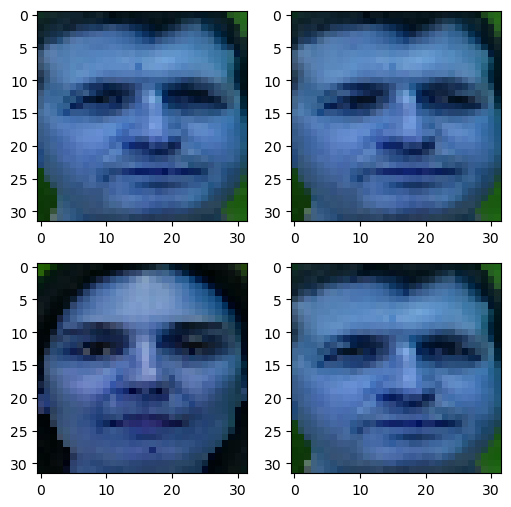

[[9.9822432e-01 1.7757255e-03]
 [6.9573569e-01 3.0426431e-01]
 [9.8720586e-01 1.2794200e-02]
 [9.9998403e-01 1.5920199e-05]]
Label #0: Real
Prediction #0: Real
Label #1: Real
Prediction #1: Real
Label #2: Real
Prediction #2: Real
Label #3: Real
Prediction #3: Real


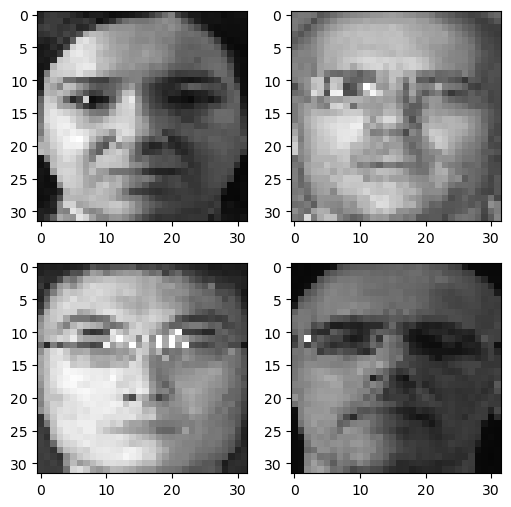

In [71]:
def show_example(trained_on: DatasetSource, test_on: DatasetSource):
    """
    Tests the model on the specified dataset.
    """
    
    model = trained_on.model()
    X, y = load_dataset_with_argmax(test_on)
    predictions = model.predict(X[:4], verbose=0)
    print(predictions)
    plt.figure(figsize=(6,6)) # specifying the overall grid size

    for i, (img, label_real, label_predicted) in enumerate(zip(X, y, predictions)):
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        print(f'Label #{i}:', 'Real' if label_real == 0 else 'Fake')
        print(f'Prediction #{i}:', 'Real' if label_predicted[0] > label_predicted[1] else 'Fake')

    plt.show()

show_example(DatasetSource.CSMAD, DatasetSource.CSMAD)
show_example(DatasetSource.MSSPOOF, DatasetSource.MSSPOOF)

# Confusion matrix displaying

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    def precision(index):
        return round(cm[index][index] / cm[:, index].sum(),2)

    def recall(index):
        return round(cm[index][index] /cm[index].sum(),2)

    def F1_score(index):
        p=precision(index)
        r=recall(index)
        return round((2 * p * r)/(p + r),2)

    plt.figure(figsize=(6, 6), dpi=80)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")



    #### CREATE THE PRECISION / RECALL / F1_SCORE TABLE ####

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fig, ax1 = plt.subplots(figsize=(10, 2 + 3 / 2.5))

    col_labels=["Bonafide", "Attacker"]
    row_labels=['Precision','Recall','F1 Score']
    row_func=[precision,recall,F1_score]
    table_vals=[]

    row_colors = np.full(len(row_labels), 'linen')
    col_colors = np.full(len(col_labels), 'lavender')


    for i in range(0, len(row_labels)):
        row=[]

        for j in range(0, len(col_labels)):
            row.append(row_func[i](j))

        table_vals.append(row)


    # the rectangle is where I want to place the table
    table = plt.table(cellText=table_vals,
                  cellLoc='center',
                  rowColours=row_colors,
                  rowLabels=row_labels,
                  rowLoc='center',
                  colColours=col_colors,
                  colLabels=col_labels,
                  loc='center')
    table.scale(1, 2)
    ax1.axis('off')

class_names = {"Bonafide", "Attacker"}

# Printing confusion matrices!

--- Model 1 on dataset 1 ---
--- Model 1 on dataset 2 ---
--- Model 1 on dataset 3 ---
--- Model 1 on dataset 4 ---
--- Model 1 on dataset 5 ---
--- Model 2 on dataset 1 ---
--- Model 2 on dataset 2 ---
--- Model 2 on dataset 3 ---
--- Model 2 on dataset 4 ---
--- Model 2 on dataset 5 ---
--- Model 3 on dataset 1 ---


/var/folders/v0/zz8w2jg50k15rrlj48nht3l00000gn/T/ipykernel_923/3323532577.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 6), dpi=80)


--- Model 3 on dataset 2 ---
--- Model 3 on dataset 3 ---
--- Model 3 on dataset 4 ---
--- Model 3 on dataset 5 ---
--- Model 4 on dataset 1 ---
--- Model 4 on dataset 2 ---
--- Model 4 on dataset 3 ---
--- Model 4 on dataset 4 ---
--- Model 4 on dataset 5 ---
--- Model 5 on dataset 1 ---
--- Model 5 on dataset 2 ---
--- Model 5 on dataset 3 ---
--- Model 5 on dataset 4 ---
--- Model 5 on dataset 5 ---


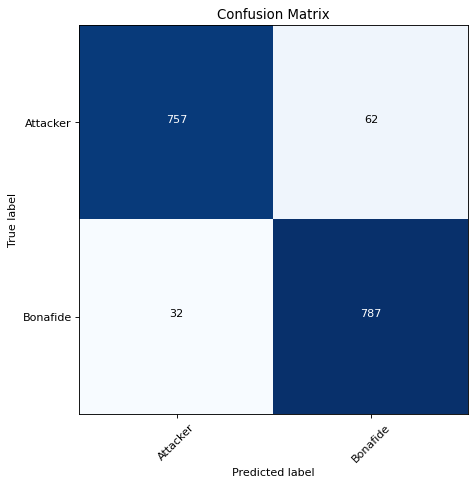

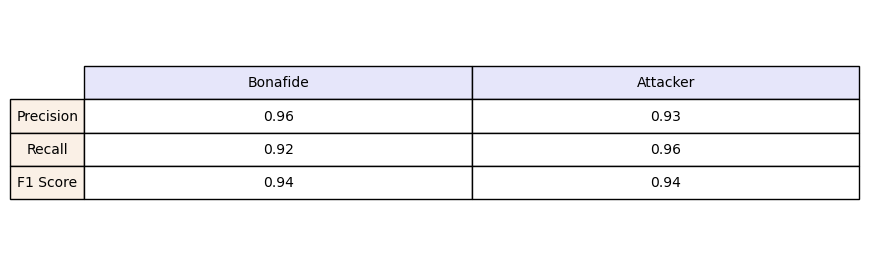

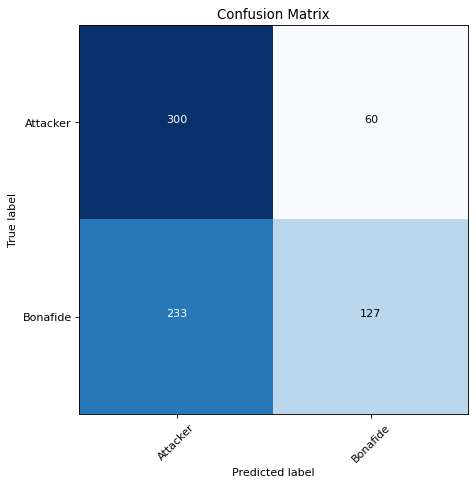

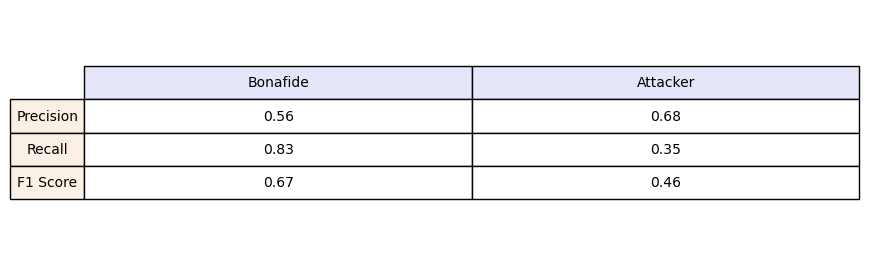

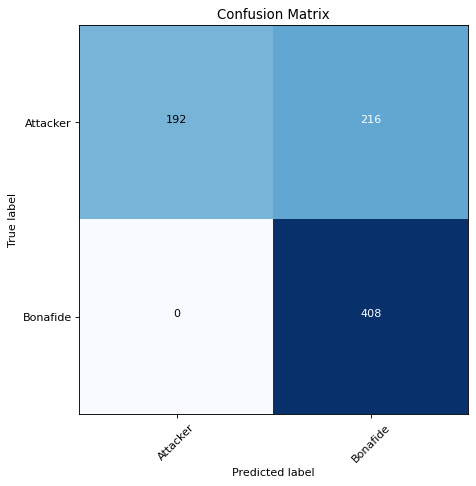

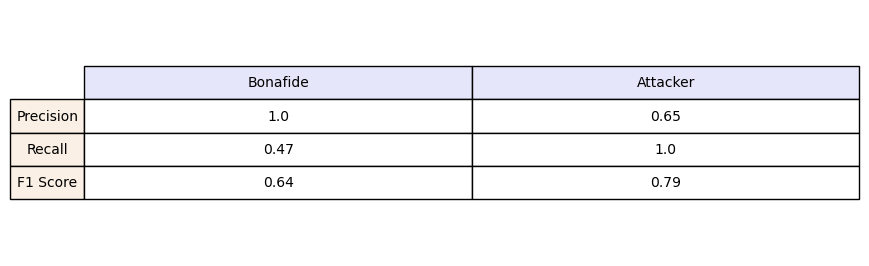

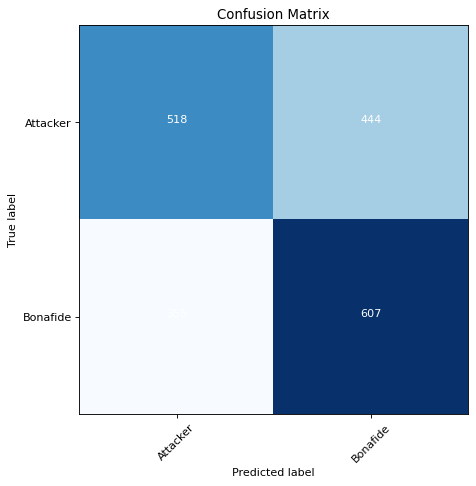

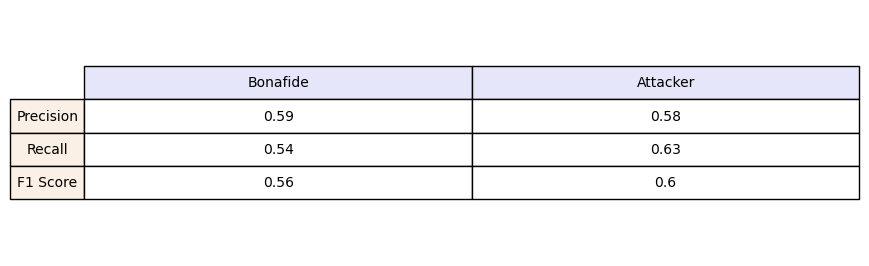

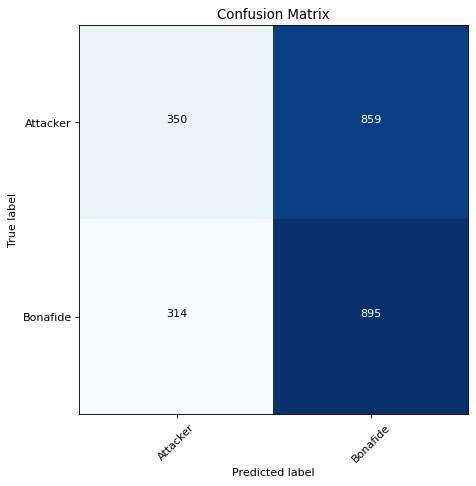

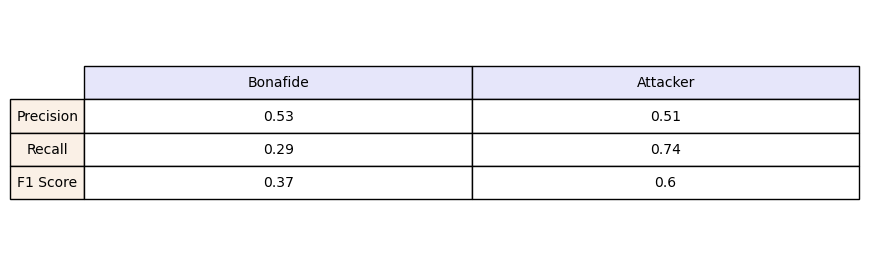

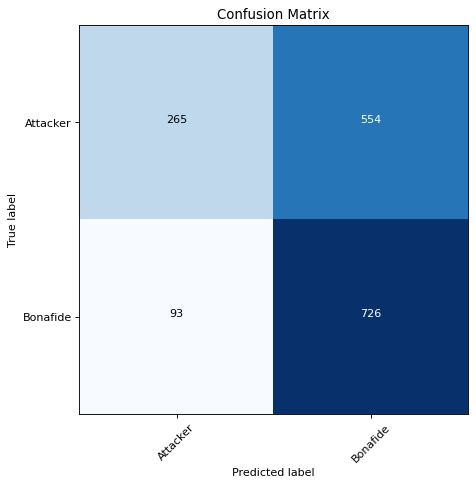

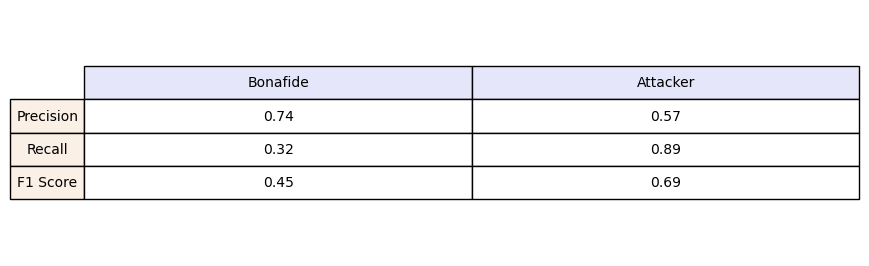

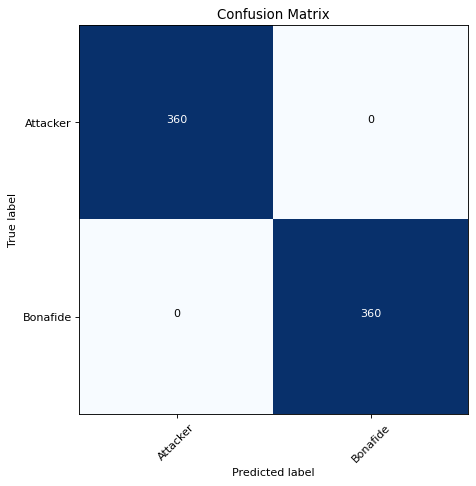

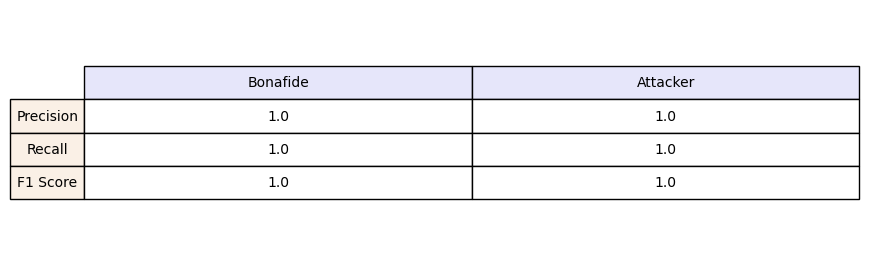

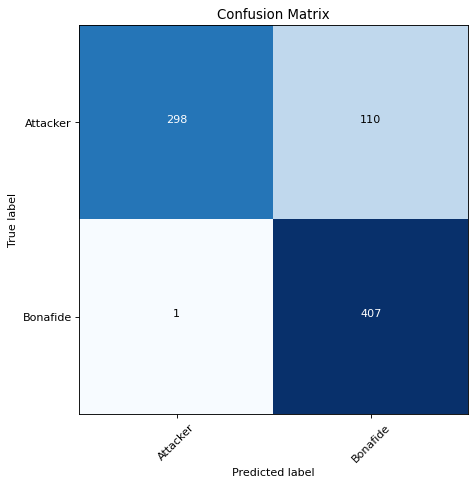

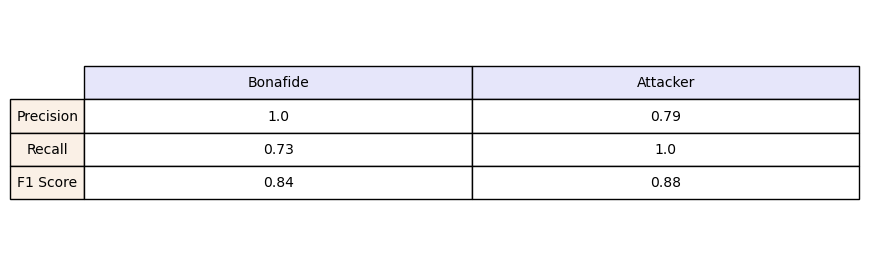

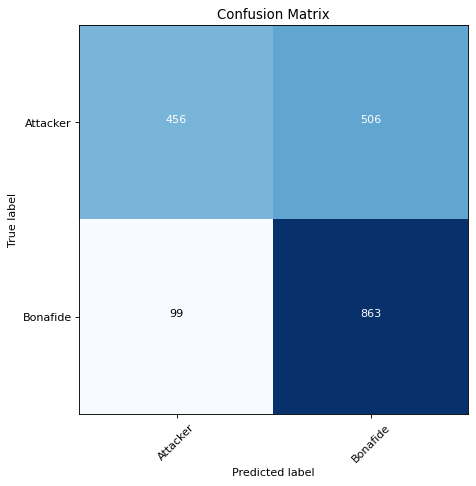

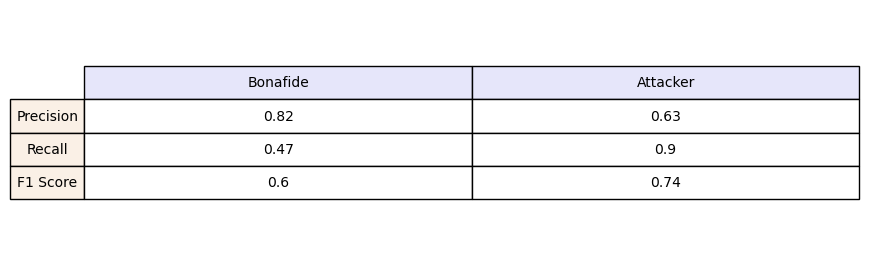

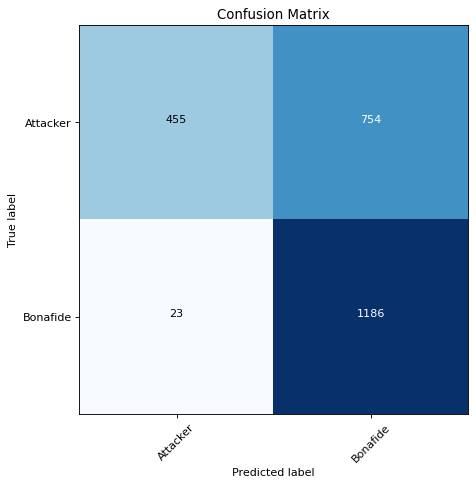

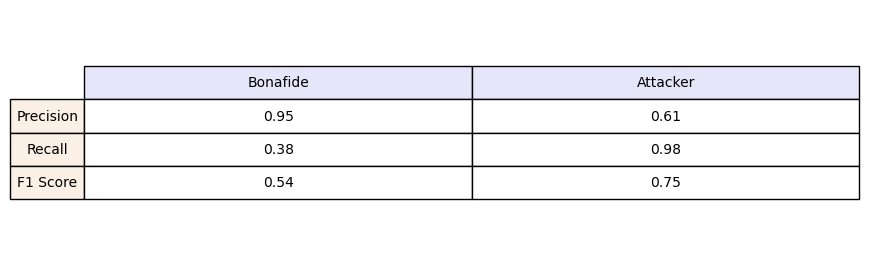

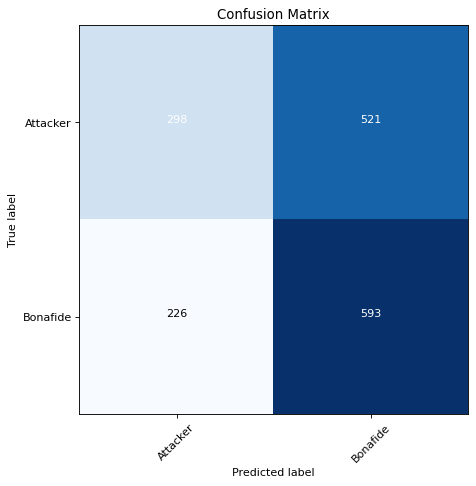

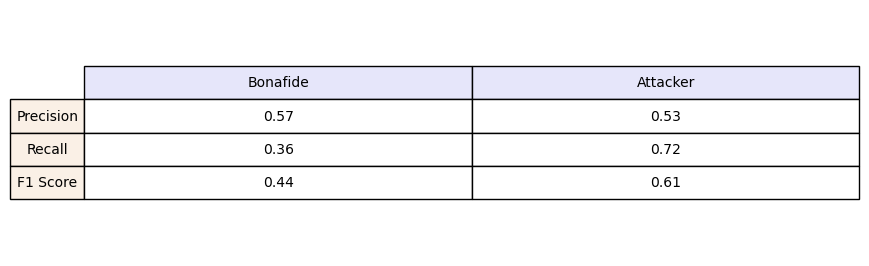

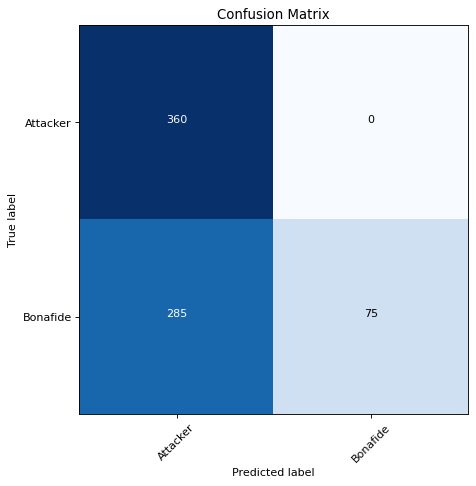

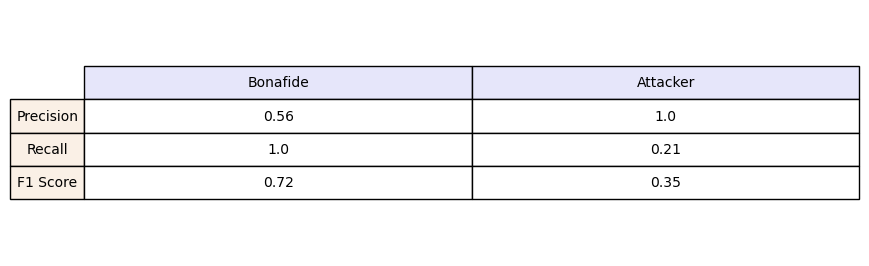

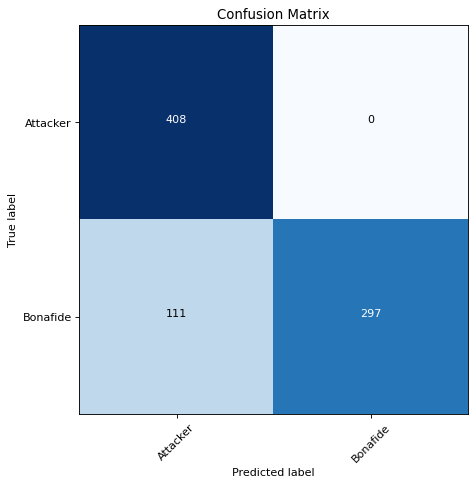

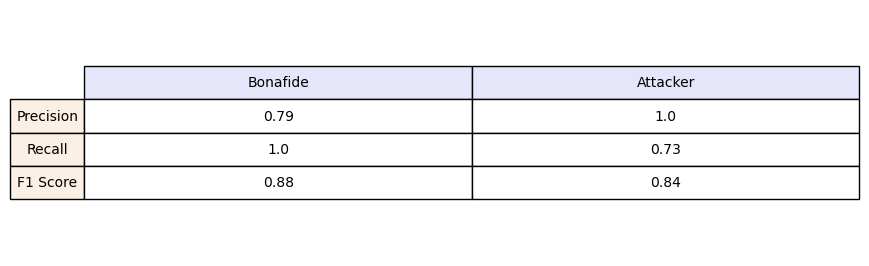

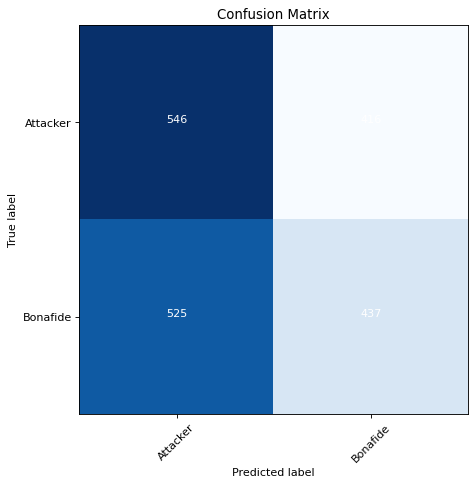

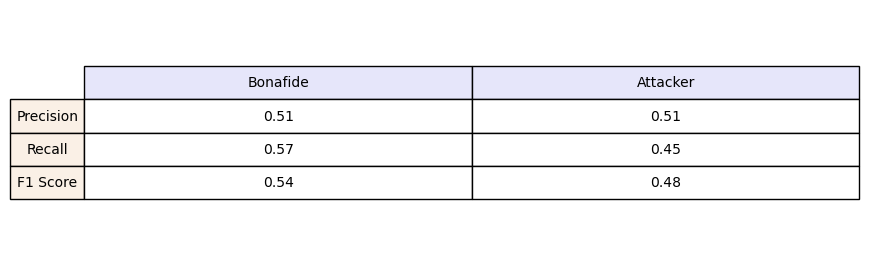

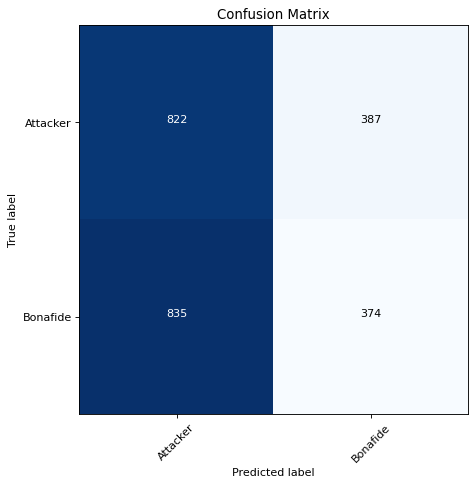

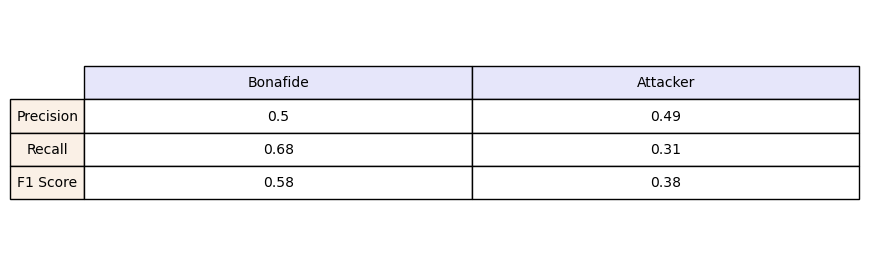

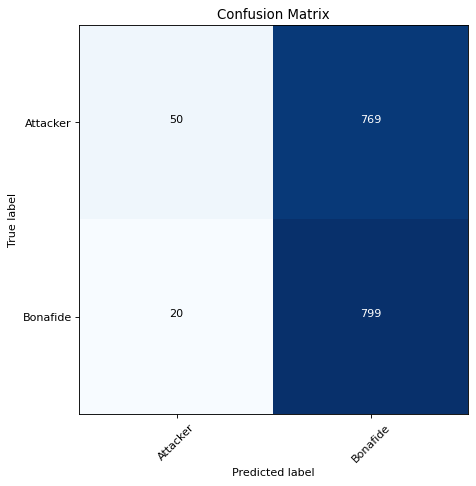

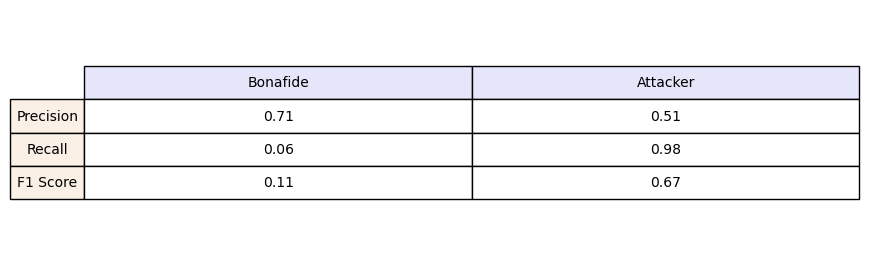

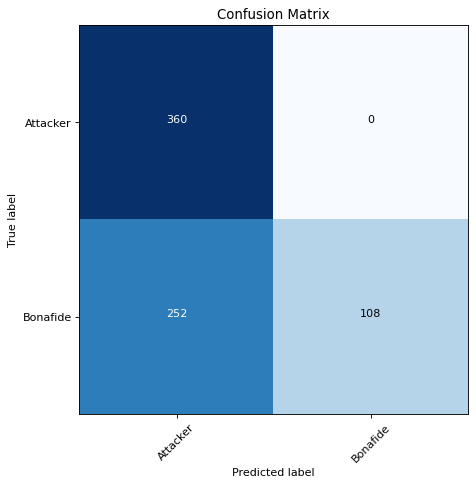

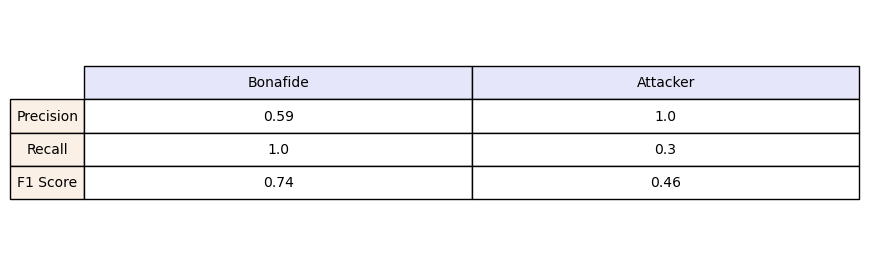

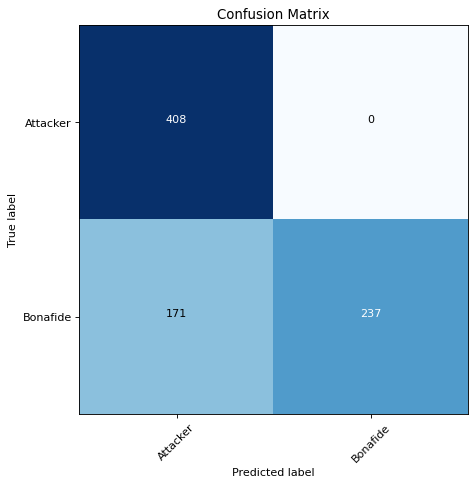

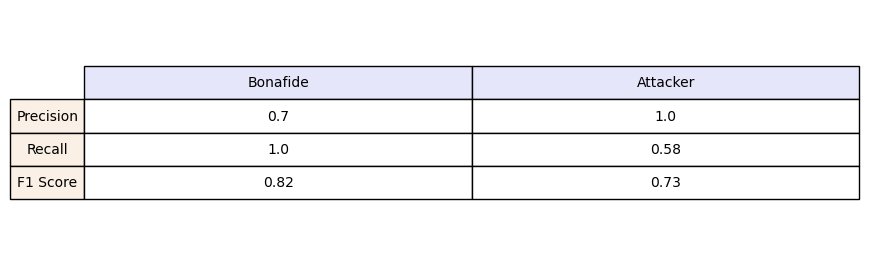

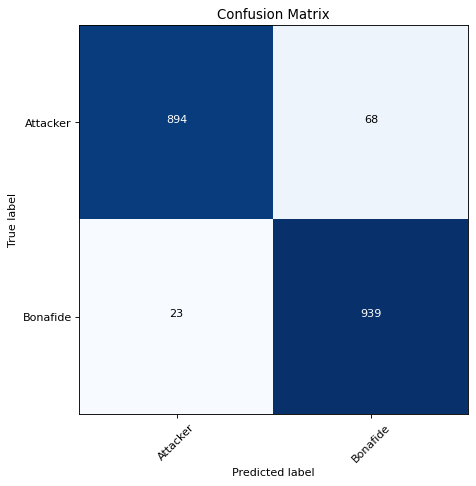

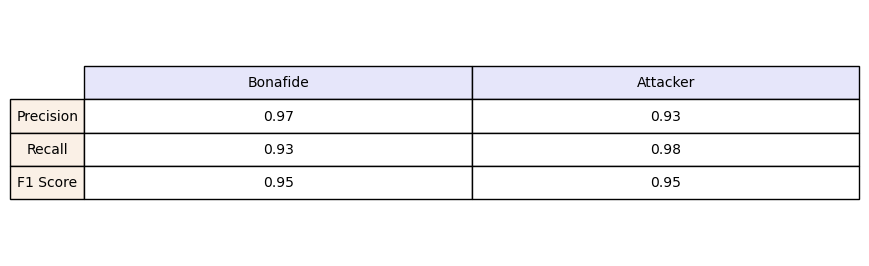

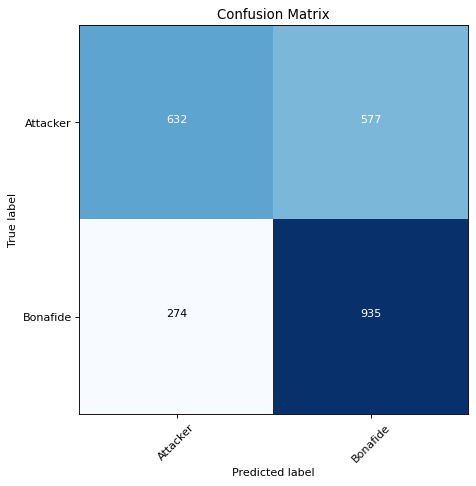

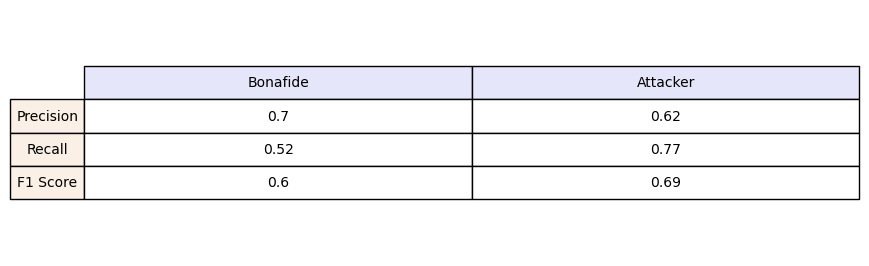

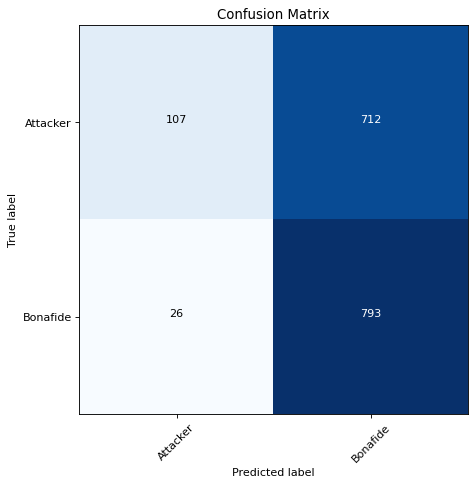

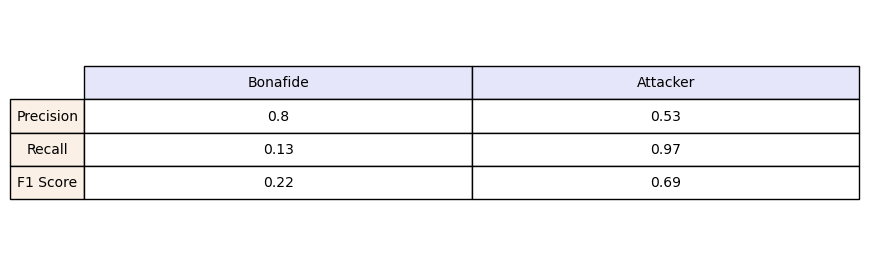

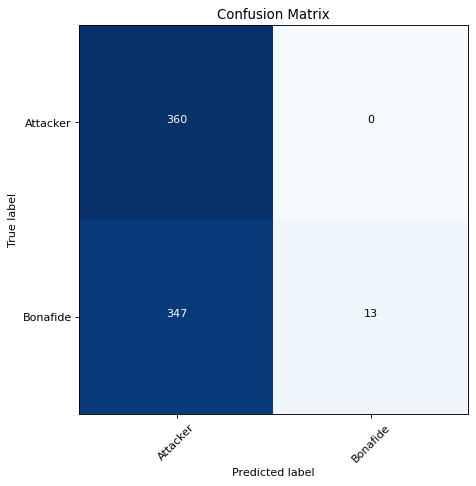

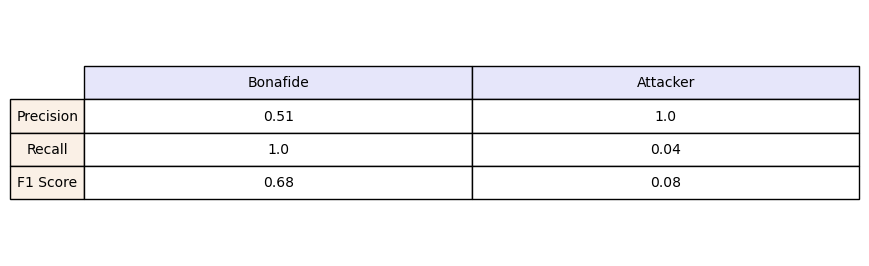

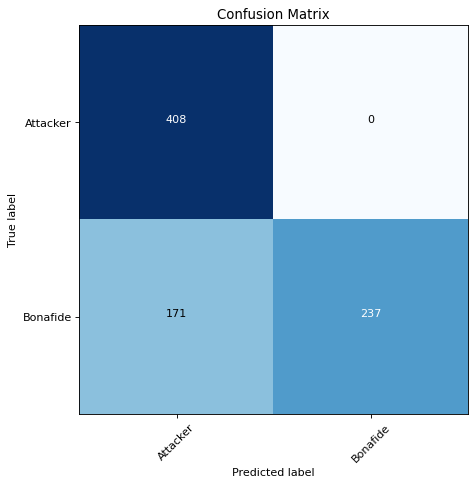

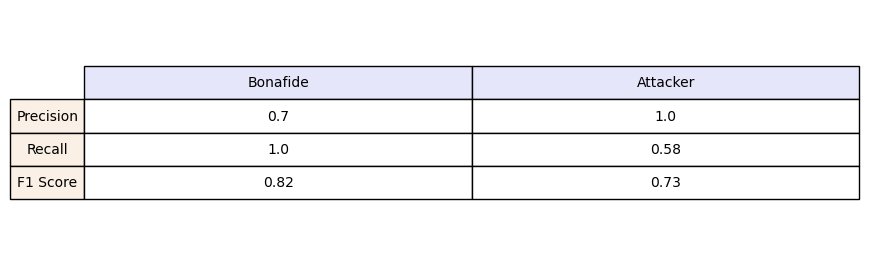

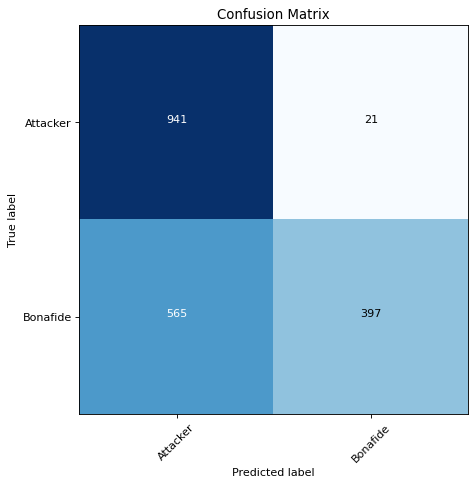

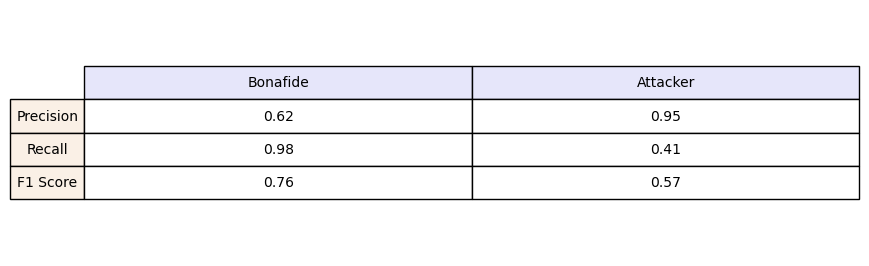

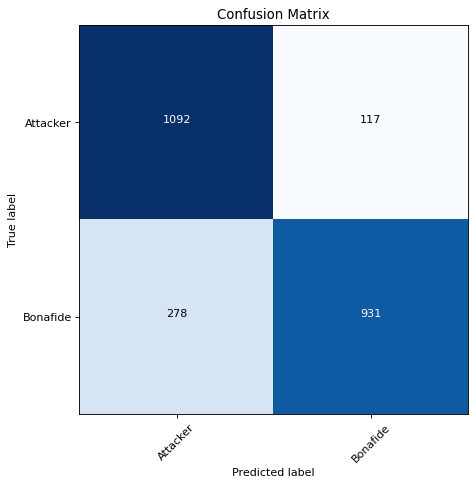

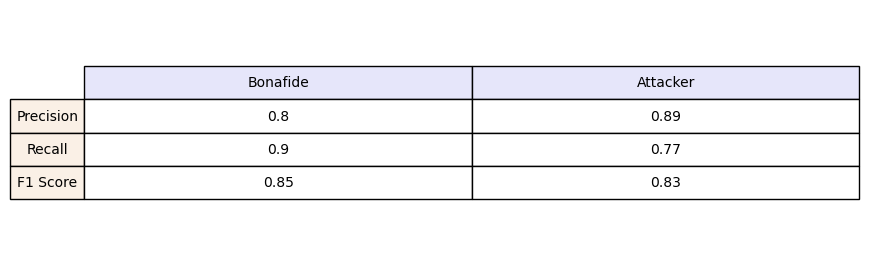

In [73]:
for trained_on in DatasetSource.to_list():
    for validate_on in DatasetSource.to_list():
        model = trained_on.model()
        _, X, _, y = DatasetLoader.load_dataset(validate_on)
        
        # one might uncomment the line below for the debugging purposes
        # test_model_dataset(model, (X, Y))
        
        y_true = np.argmax(y, axis=1)
        y_score = model.predict(X, verbose=0)
        y_prediction = np.argmax(y_score, axis=1)
        # Compute confusion matrix
        print(f'--- Model {trained_on} on dataset {validate_on} ---')
        cnf_matrix = confusion_matrix(y_true, y_prediction)

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title='Confusion Matrix')